In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta


# importing the sys module
import sys         

sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        
 

from main import *
from FinancialData import *

C:\Users\omirinioui\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Data extraction & Portfolio construction :

In [2]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 
ZCR

,Time,Rate
0,0.002740,0.025852
1,0.083333,0.026139
2,0.500000,0.023282
3,1.000000,0.022931
4,2.000000,0.023921
5,3.000000,0.026613
6,4.000000,0.029313
7,5.000000,0.031783
8,6.000000,0.034012
9,7.000000,0.036106


In [3]:
nbr_fx =  3
nbr_swap = 100
portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=list(np.arange(1, 7 + 0.5, 0.5)),
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)
#portfolio.irs_specs

## Model parameters & diffusion :

In [4]:
def Random_correlation_matrix(n):
    rho = np.random.uniform(0, 1, (n, n))
    rho = (rho + rho.T) / 2
    np.fill_diagonal(rho, 1)
    rho = np.round(rho, 3)
    return rho

In [5]:
model_params = Model_params(nbr_fx)
cov_matrix = Random_correlation_matrix(2*nbr_fx-1)
# model_params.LGM_params, model_params.FX_params, cov_matrix

In [6]:
T = portfolio.last_maturity

tt= time()
diffusion = Multi_FX_Diffusion(0, T, 3000, [ZC for i in range(nbr_fx)], model_params, 10**4, pb_measure='Risk Neutral',
                 cov_matrix= cov_matrix)
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )

Diffusion Time 0:00:14


## CVA calculation :

In [7]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

CVA calculation Time 0:03:04
 CVA value :  510.9682555722584


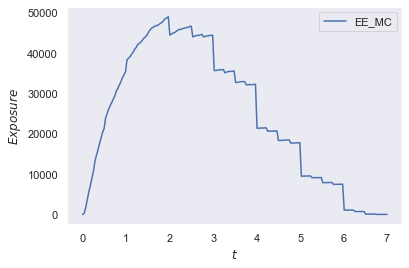

In [8]:
time_grid = np.linspace(0,T,200)

tt = time()

EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)]) for t in time_grid])
PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])

Y = (1-R)*EE*PD
CVA = (np.diff(time_grid)*Y[1:]).sum()

print( 'CVA calculation Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )
print(' CVA value : ' , CVA)

plt.plot(time_grid, EE, label="EE_MC")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$Exposure$")
plt.grid(False)
plt.show()